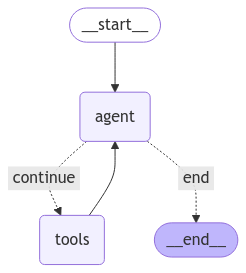

================================ Human Message =================================

三藩当前的时间和气温
================================ Human Message =================================

三藩当前的时间和气温
================================== Ai Message ==================================
Tool Calls:
  get_time (call_0_593751c7-6538-433e-87f1-28a947a8dab5)
 Call ID: call_0_593751c7-6538-433e-87f1-28a947a8dab5
  Args:
    location: 三藩
  get_weather (call_1_e674fd51-3934-4aa7-bc31-beba1b17189e)
 Call ID: call_1_e674fd51-3934-4aa7-bc31-beba1b17189e
  Args:
    location: 三藩
================================ Human Message =================================

三藩当前的时间和气温
================================== Ai Message ==================================
Tool Calls:
  get_time (call_0_593751c7-6538-433e-87f1-28a947a8dab5)
 Call ID: call_0_593751c7-6538-433e-87f1-28a947a8dab5
  Args:
    location: 三藩
  get_weather (call_1_e674fd51-3934-4aa7-bc31-beba1b17189e)
 Call ID: call_1_e674fd51-3934-4aa7-bc31-beba1b17189e
  Args:
  

In [31]:
from typing import (
    Annotated,
    Sequence,
    TypedDict,
)
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    """代理的状态。"""

    # add_messages 是一个 reducer
    # 参见 https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers
    messages: Annotated[Sequence[BaseMessage], add_messages]
    
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool

import os
from dotenv import load_dotenv

# 加载环境变量（如果有）
load_dotenv()

# 设置 API 密钥和基础 URL
model = ChatOpenAI(
    model="deepseek-chat",
    api_key="sk-16a90ba86cfc4dcf9402bea1309c9021",  # 请替换为您的实际 API 密钥
    base_url="https://api.deepseek.com"
)

# 引入 DuckDuckGoSearchRun
from langchain_community.tools import DuckDuckGoSearchRun

# 初始化 DuckDuckGo 搜索工具
search = DuckDuckGoSearchRun()

@tool
def get_weather(location: str):
    """调用以获取特定位置的天气。"""
    # 如果地点是旧金山，使用预设的回答
    if any([city in location.lower() for city in ["sf", "san francisco", "旧金山"]]):
        return "旧金山天气晴朗，但如果你是双子座，最好小心点 😈。"
    else:
        # 使用 DuckDuckGoSearchRun 获取天气信息
        query = f"{location} 天气"
        try:
            result = search.invoke(query)
            # 处理搜索结果，根据需要提取有用信息
            return f"{location}的天气信息：{result}"
        except Exception as e:
            return f"获取天气信息时发生错误：{str(e)}"

# 添加一个新的函数调用
@tool
def get_time(location: str):
    """调用以获取特定位置的当前时间。"""
    # 这是实际实现的占位符
    # 不要让 LLM 知道这一点 😊
    if any([city in location.lower() for city in ["new york", "nyc", "纽约"]]):
        return "纽约现在是上午10点。"
    else:
        return f"我不确定 {location} 的当前时间"

tools = [get_weather, get_time]

model = model.bind_tools(tools)

import json
from langchain_core.messages import ToolMessage, SystemMessage
from langchain_core.runnables import RunnableConfig

tools_by_name = {tool.name: tool for tool in tools}

# 定义我们的工具节点
def tool_node(state: AgentState):
    outputs = []
    for tool_call in state["messages"][-1].tool_calls:
        location = tool_call["args"]["location"]
        tool_result = tools_by_name[tool_call["name"]].invoke(input=location)  # 正确传递 'input' 参数
        outputs.append(
            ToolMessage(
                # 设置 ensure_ascii=False 以显示中文字符
                content=json.dumps(tool_result, ensure_ascii=False),
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )
    return {"messages": outputs}

# 定义调用模型的节点
def call_model(
    state: AgentState,
    config: RunnableConfig,
):
    # 这类似于使用 state_modifier 自定义 create_react_agent，但更灵活
    system_prompt = SystemMessage(
        "你是一个乐于助人的 AI 助手，请尽你所能回应用户的查询！"
    )
    response = model.invoke([system_prompt] + state["messages"], config)
    # 我们返回一个列表，因为这将被添加到现有列表中
    return {"messages": [response]}

# 定义决定是否继续的条件边
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    # 如果没有函数调用，那么我们结束
    if not last_message.tool_calls:
        return "end"
    # 否则，如果有，我们继续
    else:
        return "continue"

from langgraph.graph import StateGraph, END

# 定义一个新的图
workflow = StateGraph(AgentState)

# 定义我们将循环的两个节点
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# 将入口点设置为 `agent`
# 这意味着这个节点是首先被调用的
workflow.set_entry_point("agent")

# 我们现在添加一个条件边
workflow.add_conditional_edges(
    # 首先，我们定义起始节点。我们使用 `agent`。
    # 这意味着这是在调用 `agent` 节点后采取的边。
    "agent",
    # 接下来，我们传入将决定下一个调用哪个节点的函数。
    should_continue,
    # 最后我们传入一个映射。
    # 键是字符串，值是其他节点。
    # END 是一个特殊节点，表示图应结束。
    # 将会发生的是我们将调用 `should_continue`，然后它的输出将与此映射中的键匹配。
    # 根据匹配的结果，将调用相应的节点。
    {
        # 如果是 `tools`，则调用工具节点。
        "continue": "tools",
        # 否则我们结束。
        "end": END,
    },
)

# 我们现在从 `tools` 添加一个普通边到 `agent`。
# 这意味着在调用 `tools` 之后，将调用 `agent` 节点。
workflow.add_edge("tools", "agent")

# 现在我们可以编译并可视化我们的图
graph = workflow.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # 这需要一些额外的依赖项，是可选的
    pass

# 用于漂亮地格式化流的辅助函数
def print_stream(stream):
    for s in stream:
        messages = s.get("messages", [])
        for message in messages:
            if isinstance(message, tuple):
                print(message)
            else:
                message.pretty_print()

# 测试输入
inputs = {"messages": [("user", "三藩当前的时间和气温")]}
print_stream(graph.stream(inputs, stream_mode="values"))
